In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from User_Classes import UserClass
from Advertising_Environment import calculate_margin, calculate_price_index
from Clairvoyant import find_optimal_bid_for_class
from Advertising.GPTS_Learner import GPTS_Learner

import warnings
warnings.filterwarnings("ignore")

# Environment

In [28]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

user = UserClass(name='C1')

#names = ['Young ', 'Old', 'Not Sporty', 'Sporty']

price = 200
T = 365
n_experiments = 5

gpts_rewards_per_experiment = []

optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))

In [20]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

In [21]:
class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        #print('Means')
        #print(self.means[pulled_arm])
        #print('Means Array')
        #print(self.means)
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

# Experiment

In [22]:
for e in tqdm(range(0, 5)):
    env = BiddingEnvironment(bids=bids, sigma = sigma, user_class=user, price=price, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)

    for t in range(T):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

100%|██████████| 5/5 [02:16<00:00, 27.36s/it]


In [23]:
gpts_rewards_per_experiment[1]

array([13535.03523483, 13860.90950522, 13894.23205921,   333.86875078,
       13783.9876827 , 13768.92616375,  7745.58879886, 13602.63628692,
       13592.91358023,  3712.11986211, 13457.02686307, 13575.29206731,
       13907.41716316, 13810.59417975, 12479.98417368, 13827.5348275 ,
       13540.99701214, 13897.96393574, 13860.88941225, 14114.03255847,
       14088.6998246 , 13792.85402466, 13692.47534089, 13498.43869169,
       13592.24621125, 13652.4042259 , 11876.08083767, 13253.93267389,
       13443.6666906 , 13677.18028612, 13443.67969728, 14006.15605531,
       13604.10703667, 13886.79756777, 13678.06397243,   462.29700154,
       13398.05199603, 13788.90500377, 13163.68679675, 13459.37929469,
       13260.59999736, 10161.79615311, 13323.33845615, 11915.38338802,
       13772.52839379, 14014.36776005, 10731.39200726, 13639.01971725,
       13349.17504142, 13501.87148169,   582.6331266 , 13164.13221305,
       13861.18931794, 13815.52077303, 13383.65431278, 13572.41266713,
      

In [24]:
optimum_bid

(1.0, 13767.97338369385)

# Cumulative Regret
The cumulative regret at a given round (in our case day) t is the sum of the regrets experienced up until and including that day.

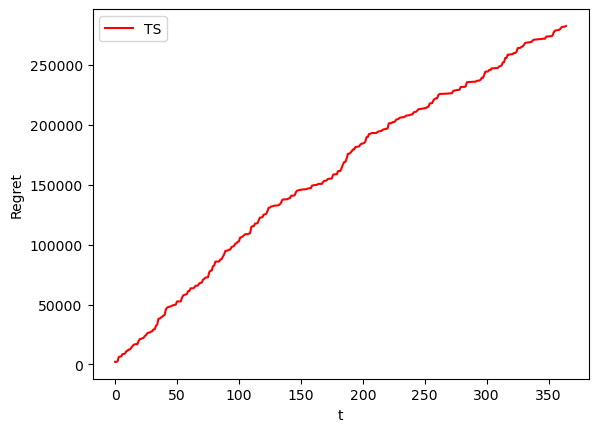

In [25]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

# Cumulative Reward

The cumulative reward at a given round (in our case day) t is the sum of the rewards received up until and including that day.

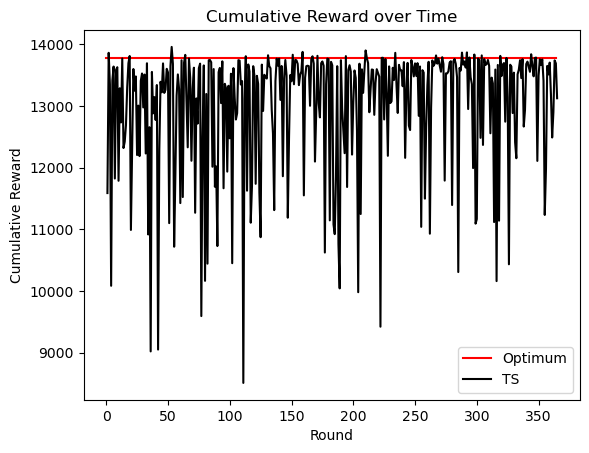

In [27]:
mean_cum_reward_ts = np.mean(gpts_rewards_per_experiment, axis=0)
std_cum_reward_ts = np.std(gpts_rewards_per_experiment, axis=0)
opt_line = np.ones(365) * optimum_bid[1]

# Plot the results
plt.plot(opt_line, 'r', label='Optimum')

plt.plot(range(1, T+1), mean_cum_reward_ts, 'k', label='TS')

plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')

plt.legend()
plt.show()

[13767.97338369 13767.97338369]


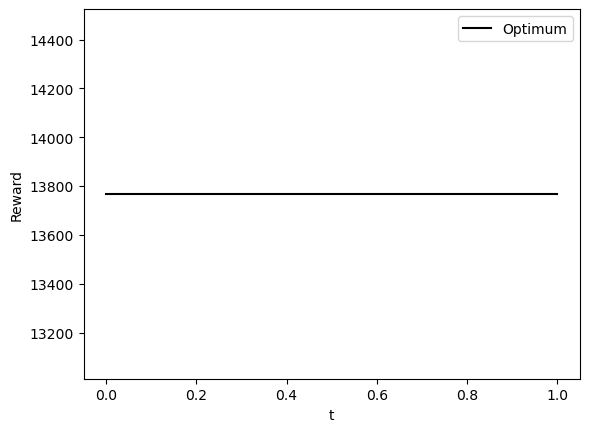

In [33]:
plt.figure(0)
plt.ylabel("Reward")
plt.xlabel("t")
opt_line = np.ones(365) * optimum_bid[1]
print(opt_line)
plt.plot(opt_line, 'k')
plt.legend(["Optimum"])
plt.show()

In [24]:
len(gpts_rewards_per_experiment)

2

[12848.59549311 13615.0739277  11597.59207329 13093.08750083
 13721.24741697 12515.58283438 13474.02100005 12710.49819867
 13523.99296898 13095.41275283 12820.5747267  12432.24164081
 12035.13940124 13497.73169705 11391.96960134  9701.40662439
 12783.8152083  12702.03598398 13722.37682799 11903.68529313
 12162.7422643  12031.30227299 12427.08307267 13000.74102972
 12956.21856941 12662.39174973 12877.59408749 11477.2028242
 13365.12821563 12498.54895368 13198.95017041 13156.20029611
 11906.15392724 13181.47152141 10854.33864741 12233.71800696
 12528.75804533 13334.62643297 13578.8695445  13273.64657024
 11281.59182819 13392.38849483 13701.70041323 11661.79596924
 13812.59256222 13336.89108953 13506.73034156 12233.3817083
 12956.53605543 13546.12610237 12998.88747945 13378.74332521
 11760.88252323 13304.07994537 11054.98294927 12479.59500795
 12556.47554805 13544.75584715 13508.90160608 12355.46343183
 12800.61272093 12433.84225797 12806.66031437 10603.4367777
 12403.66000117 11723.44685

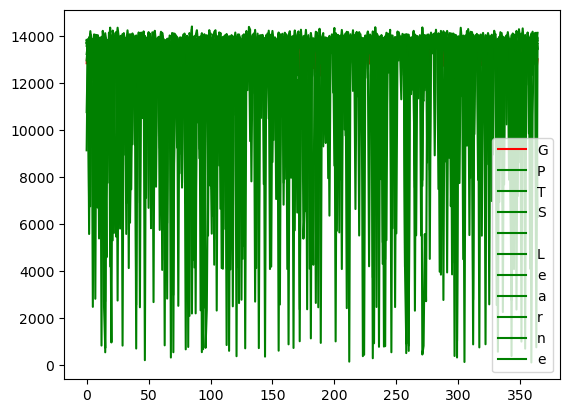

In [10]:
leg = "GPTS Learner"
maxes = []
for line in [gpts_rewards_per_experiment]:
    curve = np.nanmean(line, axis=0)
    print(curve)
    maxes.append(np.max(curve))
    #print(line)
    plt.plot(curve, "r")
    for i in range(len(gpts_rewards_per_experiment)):
        plt.plot(line[i], "g") #alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
#plt.ylim([15000, 1.2 * np.max(maxes, axis=0)])
plt.legend(leg)
plt.show()

[array([13844.66558716, 13329.8288554 , 13746.54140894,  6753.42732592,
       13843.6366621 , 13557.34884824, 10850.46392516, 13789.85810273,
       13822.60374464, 14020.73573487, 13881.81415464, 12808.71757656,
       13977.96533084, 13459.44318277, 13816.96544038,  2703.45690755,
       13763.42733058,  7756.88255176, 13902.18007899, 13749.59006995,
       14038.37706351, 13478.61180111, 13817.197447  , 12233.32715301,
       13356.50510109, 13740.1805537 ,  9867.80611018,  8516.18711908,
       11038.51719434, 13852.81667535, 13847.66382431, 13928.3002924 ,
       13686.78321163, 13807.98725114, 13720.26512551, 12594.25020947,
       12887.21535602, 13952.7736241 , 14031.16389363, 13643.03064963,
       13857.25130783, 13241.13183246, 13828.13532091,  2451.8186425 ,
       14154.6248499 , 13811.73905638, 13981.89688522, 13358.06869816,
       13362.9264875 , 13809.6081301 ,  6687.10510199, 13326.84328744,
       10568.85501633, 14164.24248748, 14158.03860374, 13455.12039197,
     

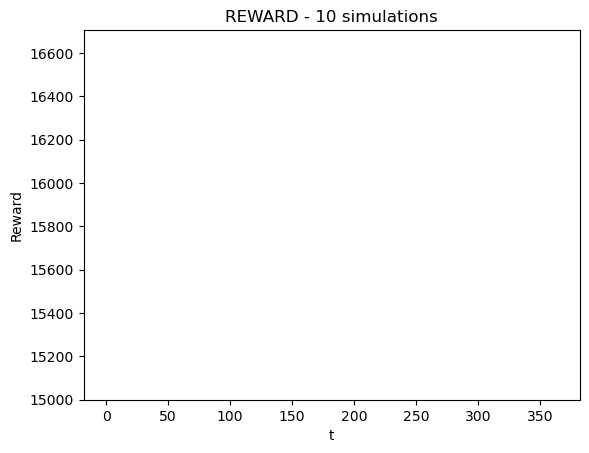

In [11]:
plt.figure(3)
plt.title("REWARD - {} simulations".format(len(gpts_rewards_per_experiment)))
plt.xlabel("t")
plt.ylabel("Reward")
leg = "GPTS Learner"
maxes = []
opt_line = np.ones(shape=len(gpts_rewards_per_experiment)) * optimum_bid[1]
plt.plot(opt_line, 'k')
for line in [gpts_rewards_per_experiment]:
    curve = np.nanmean(line, axis=0)
    maxes.append(np.max(curve))
    print(line)
    plt.plot(curve, "r")
    for i in range(len(gpts_rewards_per_experiment)):
        plt.plot(line[i], "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.ylim([15000, 1.2 * np.max(maxes, axis=0)])
#plt.legend(leg)
plt.show()

# Istantaneous Regret
Instantaneous regret is a measure of how much better you could have done on a particular day t if you had made the optimal decisions (as determined by your clairvoyant optimization algorithm). It's defined as the difference between the optimal reward and the actual reward received on day t.



# Istantaneous Reward
The instantaneous reward at a given round (or day) t would be the reward received on that particular day.